## **Download Dataset**

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="a86nTMAPVEfAne5s9OsD")
project = rf.workspace("testworkspace-7xg3d").project("dent-ecagu-9cr4p")
version = project.version(1)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Dent-1 in yolov11:: 100%|██████████| 5292/5292 [00:00<00:00, 6071.42it/s]


# **Датасет car damage**

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="a86nTMAPVEfAne5s9OsD")
project = rf.workspace("testworkspace-7xg3d").project("broken-car-od-zxfty")
version = project.version(1)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Broken-car---OD-1 in yolov11:: 100%|██████████| 9978/9978 [00:02<00:00, 3995.98it/s]


## **Train EfficientNet-B0**

In [2]:
!pip install torch torchvision timm

In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from tqdm import tqdm

In [5]:
# Пути к датасету Roboflow
DATA_DIR = "/content/dirty-2"
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Трансформации (аугментации + нормализация ImageNet)
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Загрузка датасета
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "valid"), transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# EfficientNet из timm
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=len(train_ds.classes))
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# Обучение
best_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

    # Валидация
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Validation accuracy: {acc:.4f}")
    if acc > best_acc:
        torch.save(model.state_dict(), "best_efficientnet.pth")
        best_acc = acc

print("Training finished. Best Val Acc:", best_acc)

FileNotFoundError: Found no valid file for the classes labels. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

# **Train Yolo 11**

In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00


In [3]:
import ultralytics
ultralytics.checks()


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.4/112.6 GB disk)


In [2]:
from ultralytics import YOLO

# Загружаем предобученную модель YOLOv11 (объект детекции)
model = YOLO("yolo11m.pt")  # можно yolo11s.pt, yolo11m.pt в зависимости от GPU

# Тренировка
model.train(
    data="/content/Dent-1/data.yaml",  # путь к yaml от Roboflow
    epochs=50,
    imgsz=640,
    batch=16,
    device=0  # 0 = GPU, "cpu" если без CUDA
)


ModuleNotFoundError: No module named 'ultralytics'

In [5]:
model.val()


Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,887 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1664.5±430.7 MB/s, size: 50.4 KB)
val: Scanning /content/Broken-car---OD-1/valid/labels.cache... 338 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 338/338 652.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 1.8it/s 12.3s
                   all        338        380      0.618      0.574      0.622      0.398
          broken_glass         87         91      0.803      0.802      0.879      0.704
      broken_headlight        104        104      0.827      0.781      0.864      0.599
                  dent         85         88      0.664      0.557      0.631      0.328
          major_damage         13         14      0.126     0.0714     0.0577     0.0159
               scratch         8

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2538c168a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        


image 1/1 /content/1-1200x752.webp: 416x640 1 broken_headlight, 28.7ms
Speed: 2.2ms preprocess, 28.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /content/runs/detect/train19


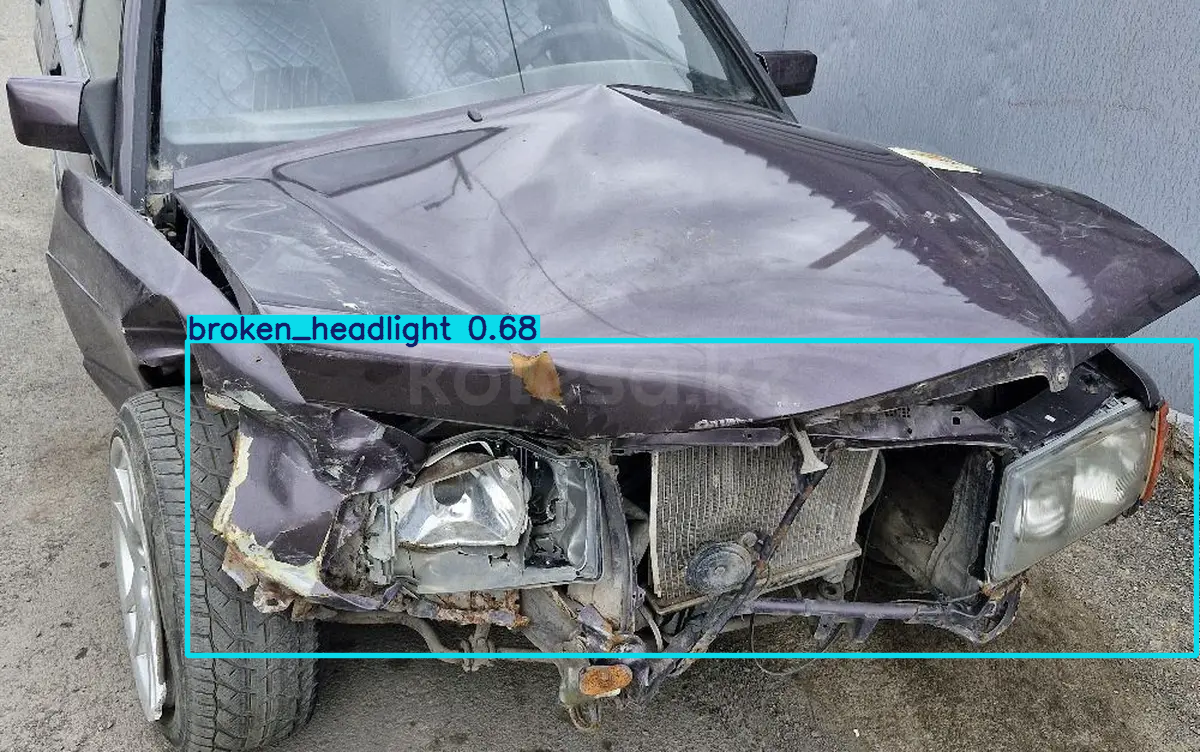

In [25]:
results = model.predict("/content/1-1200x752.webp", conf=0.2, save=True)
for r in results:
    r.show()   # показать результат прямо в ноутбуке
